# dataset-1 binary & multiclass classification

Using device: cuda
Dataset shape: (1025, 14)
Target distribution:
target
1    526
0    499
Name: count, dtype: int64
No missing values found!
Binary target distribution: [499 526]
Multiclass target distribution: [499 503  23]
Running complete experiment...

RUNNING BINARY EXPERIMENT

----------------------------------------
TECHNIQUE: No Sampling
----------------------------------------
Fold 1/5...
Fold 2/5...
Fold 3/5...
Fold 4/5...
Fold 5/5...

----------------------------------------
TECHNIQUE: SMOTE
----------------------------------------
Fold 1/5...
Fold 2/5...
Fold 3/5...
Fold 4/5...
Fold 5/5...

----------------------------------------
TECHNIQUE: SMOTETomek
----------------------------------------
Fold 1/5...
Fold 2/5...
Fold 3/5...
Fold 4/5...
Fold 5/5...

RUNNING MULTICLASS EXPERIMENT

----------------------------------------
TECHNIQUE: No Sampling
----------------------------------------
Fold 1/5...
Fold 2/5...
Fold 3/5...
Fold 4/5...
Fold 5/5...

---------------------------

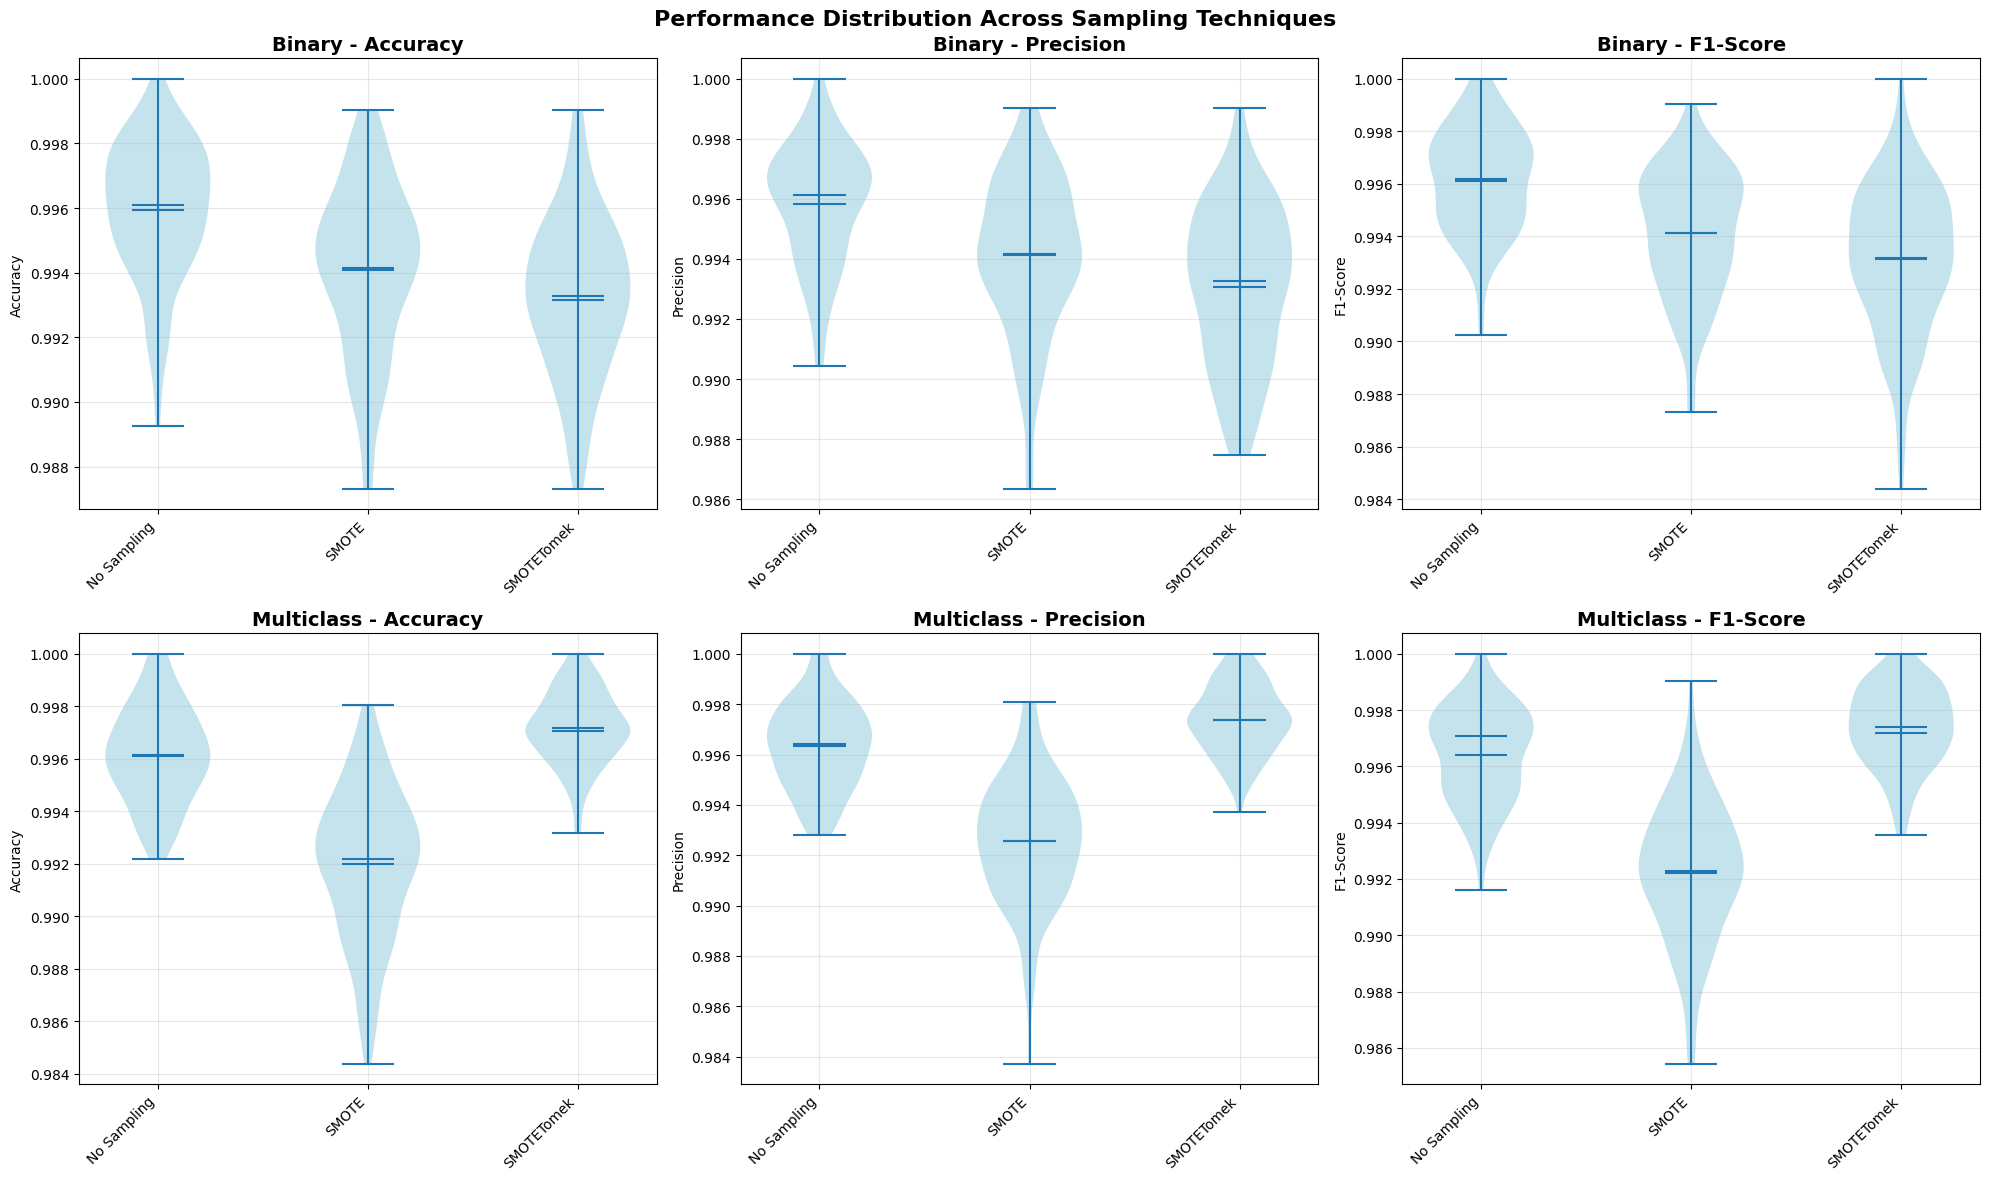

  0%|          | 0/2 [00:00<?, ?it/s]

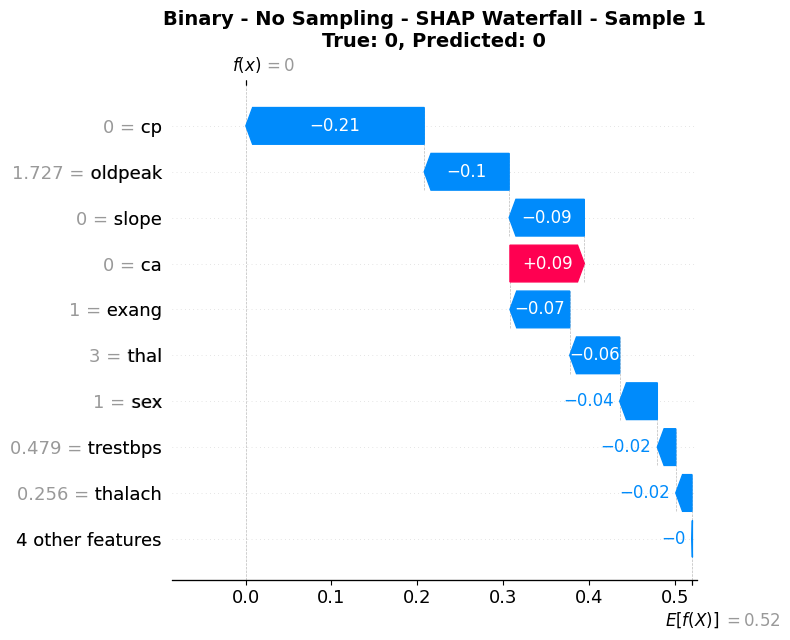

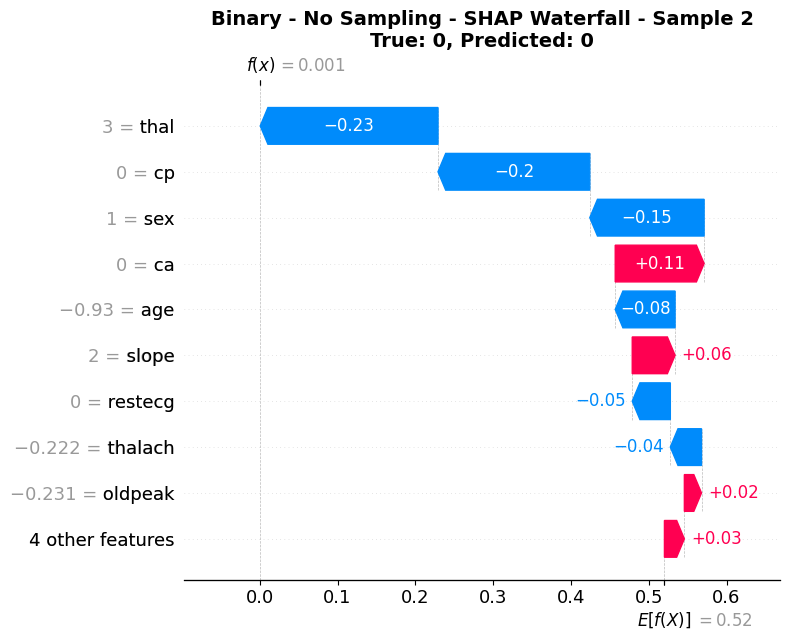

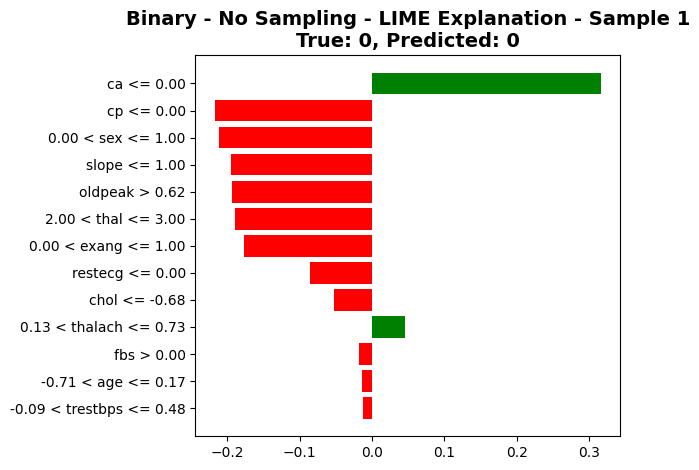

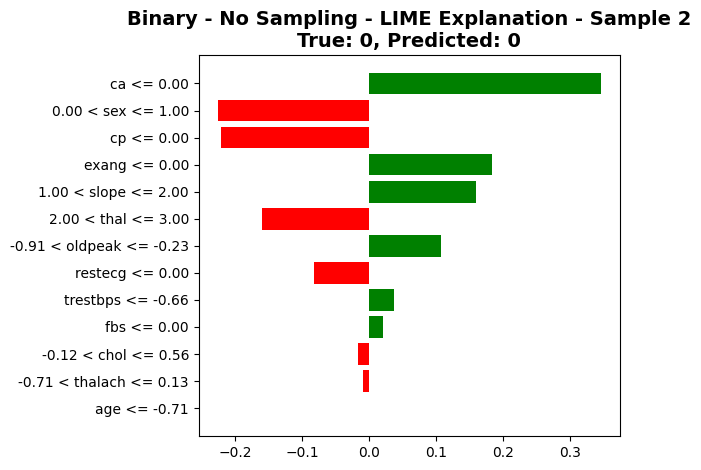

  0%|          | 0/2 [00:00<?, ?it/s]

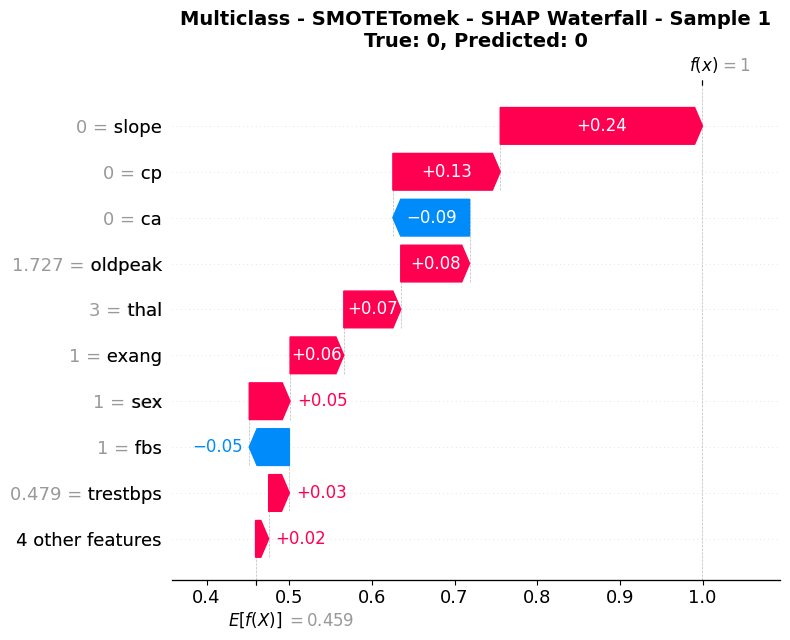

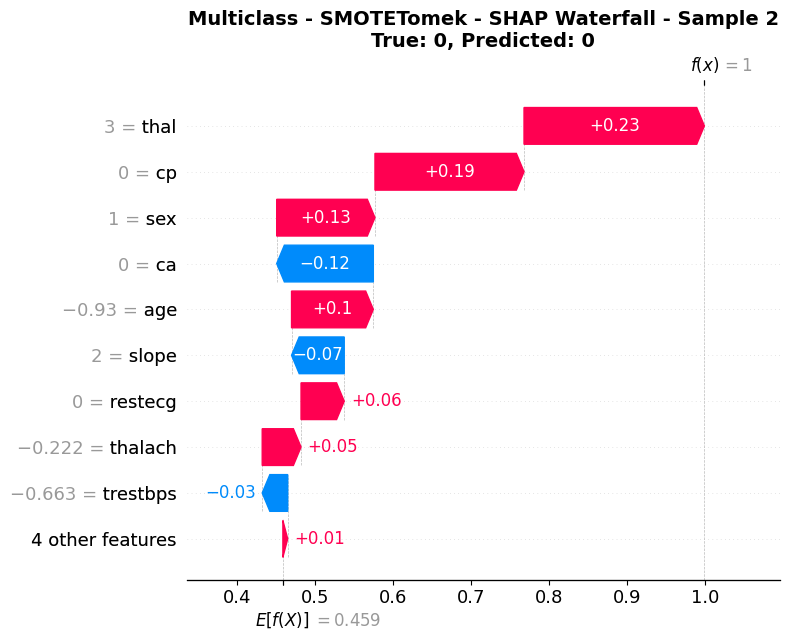

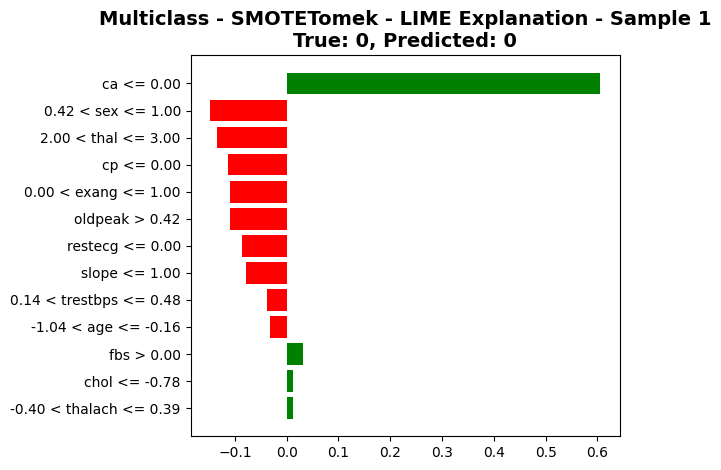

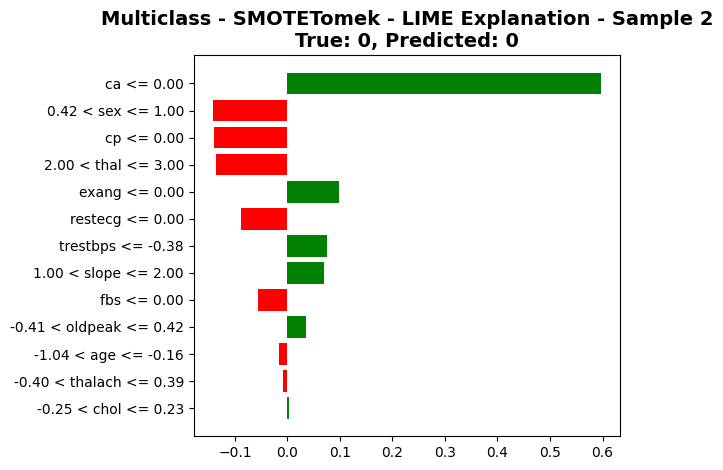


2. CREATING AVERAGE CONFUSION MATRICES


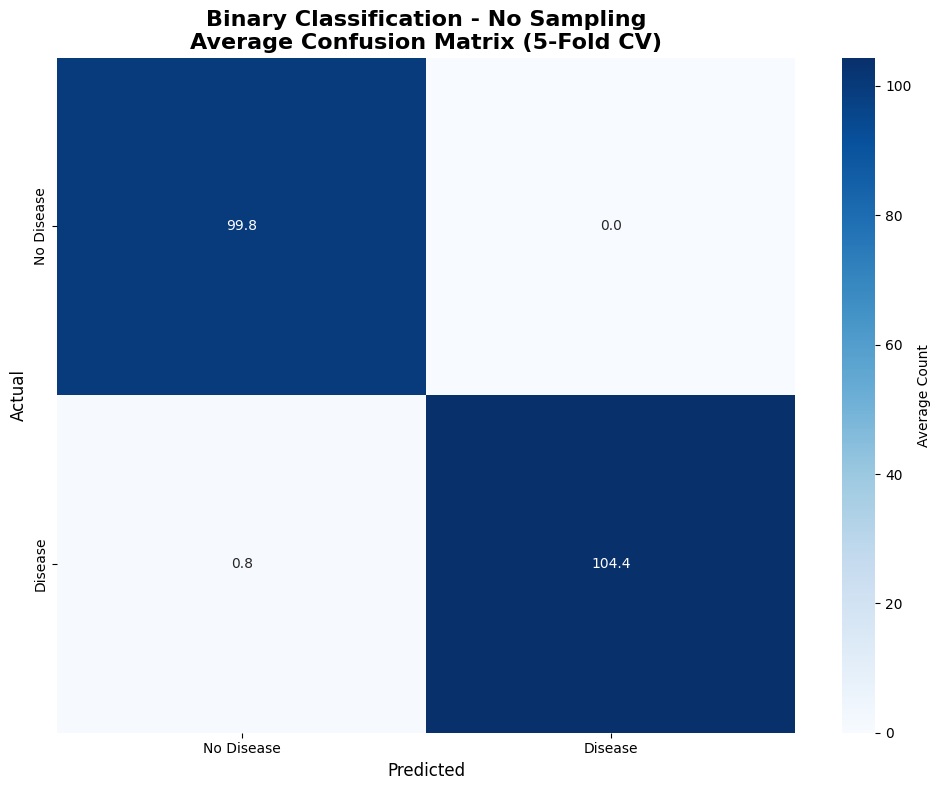

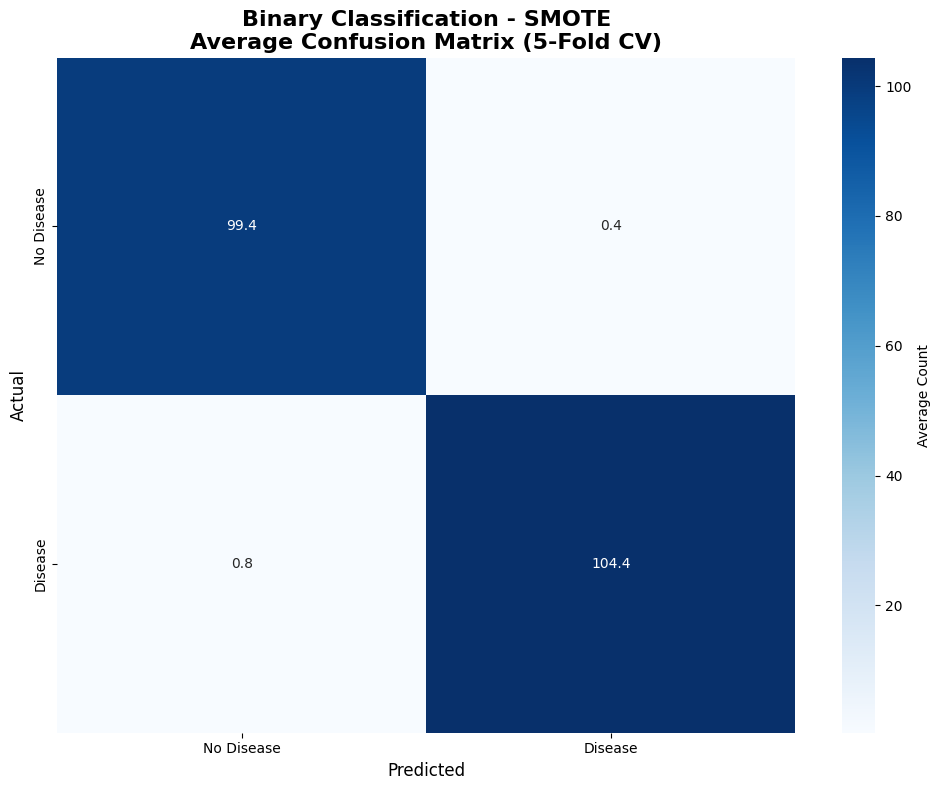

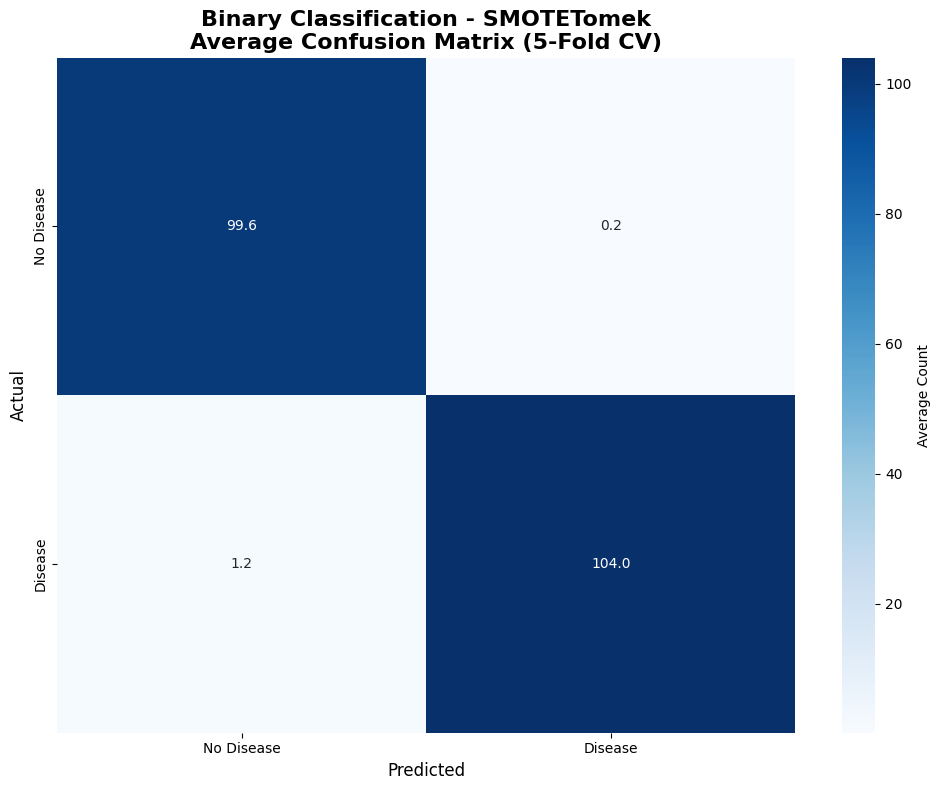

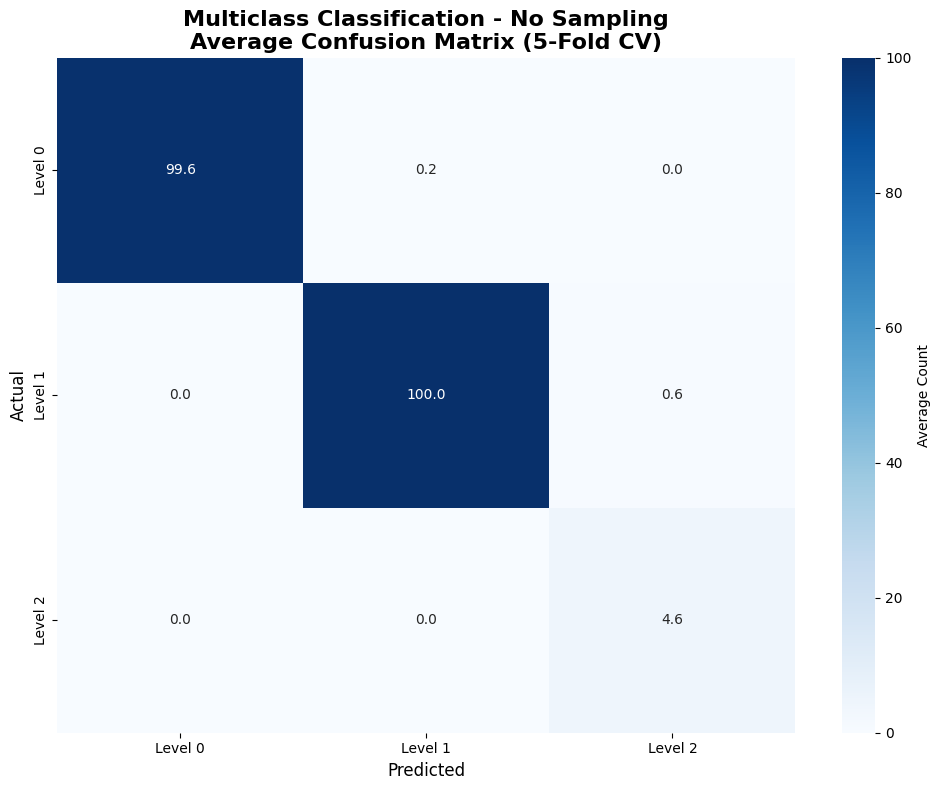

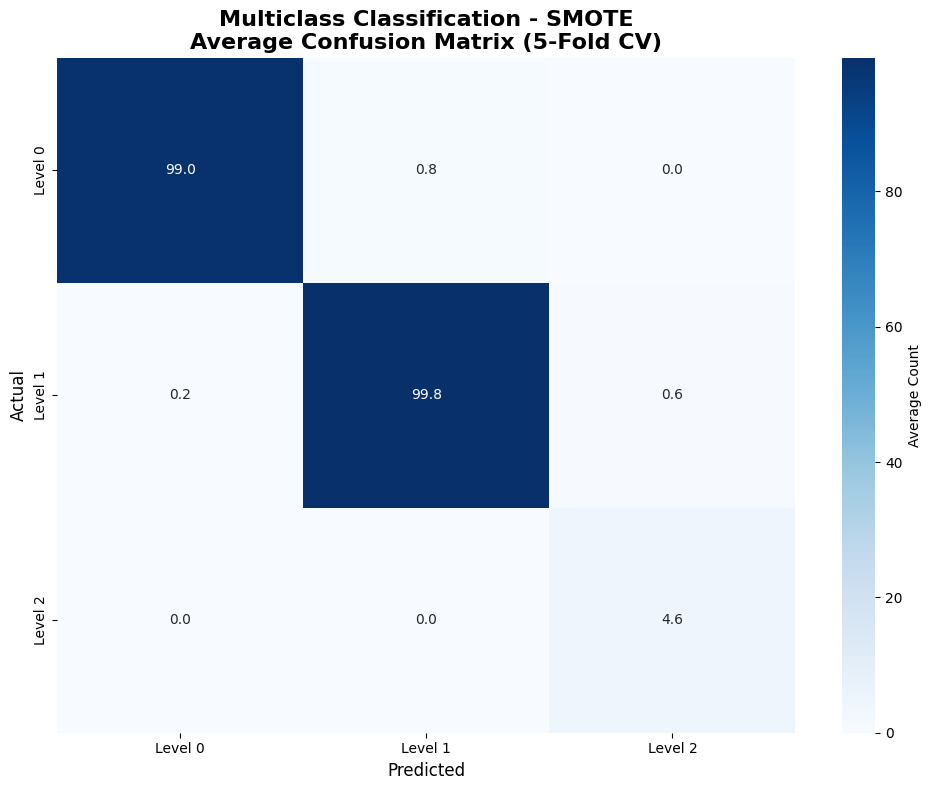

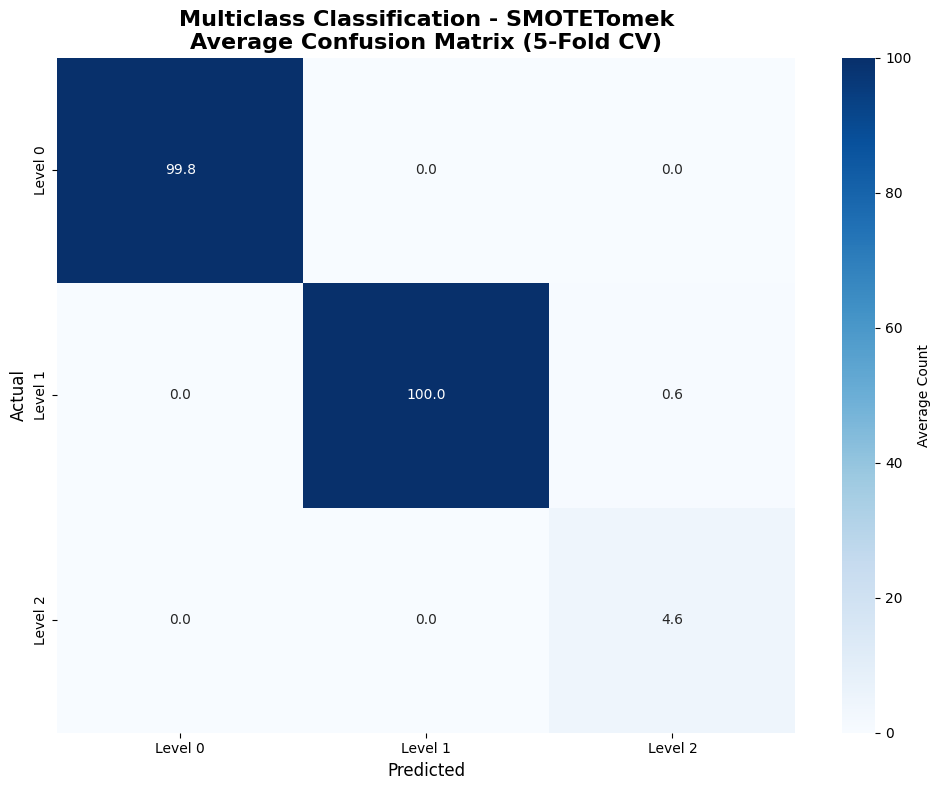


3. CREATING ROC CURVES (5-FOLD COMBINED)


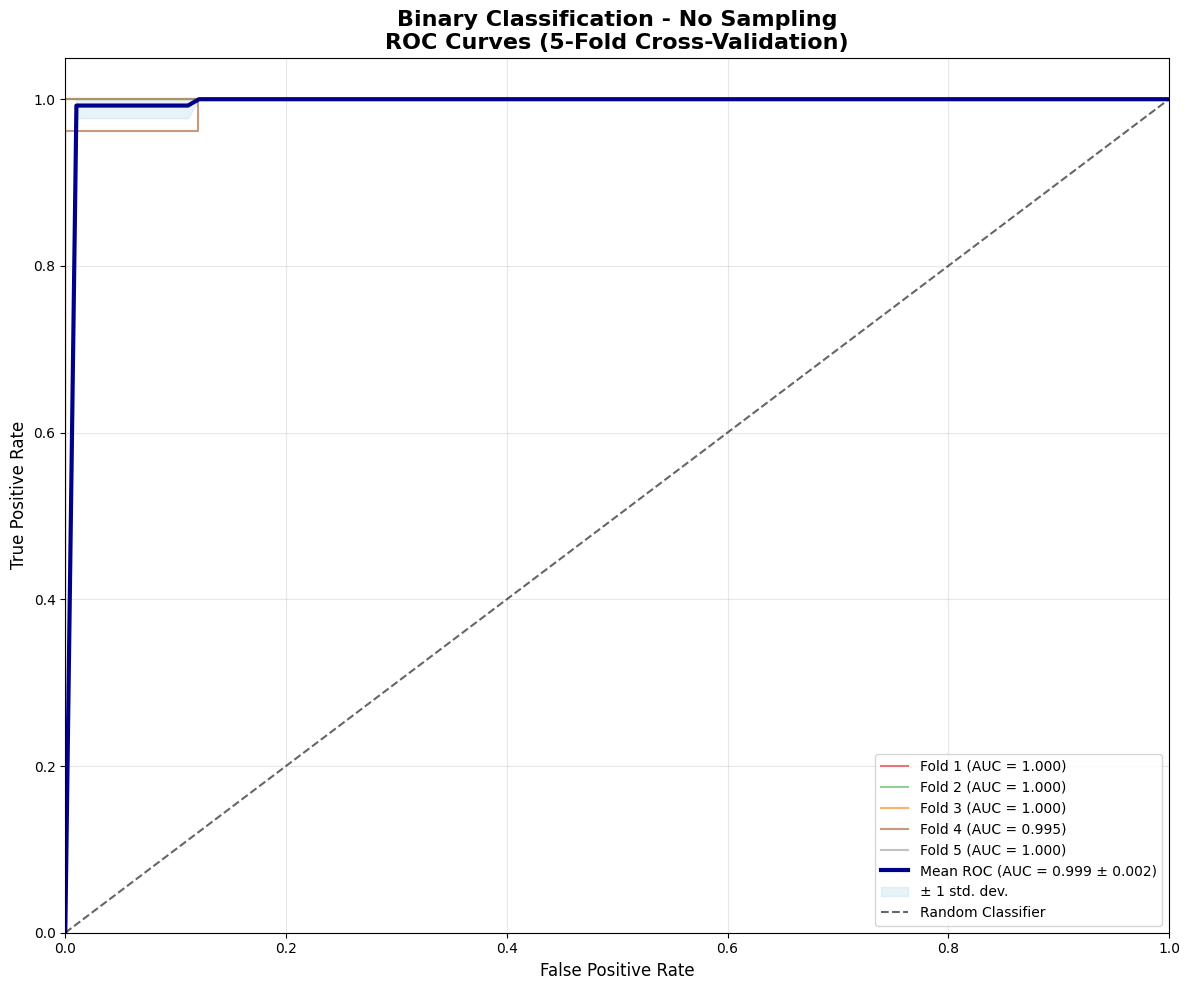

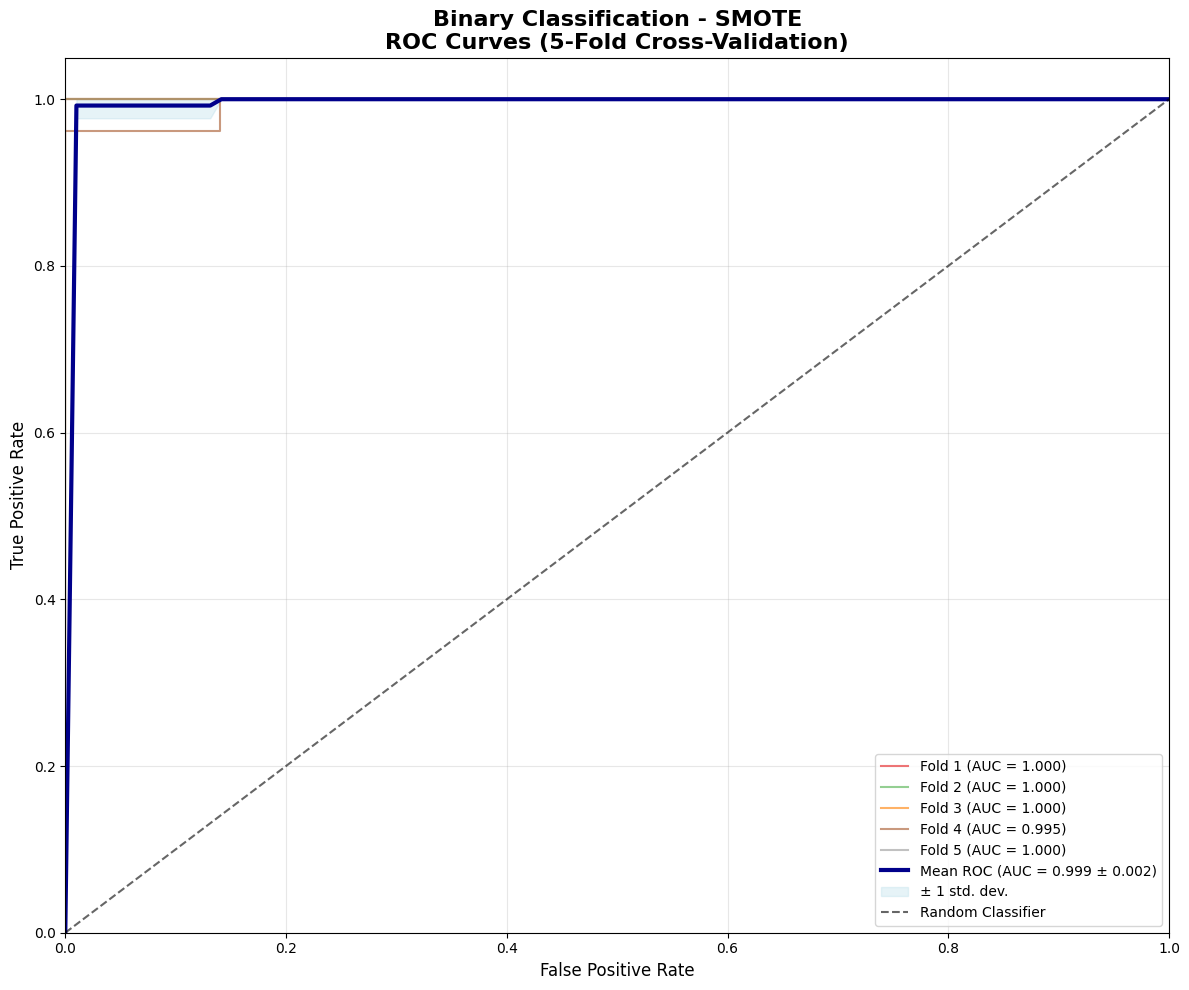

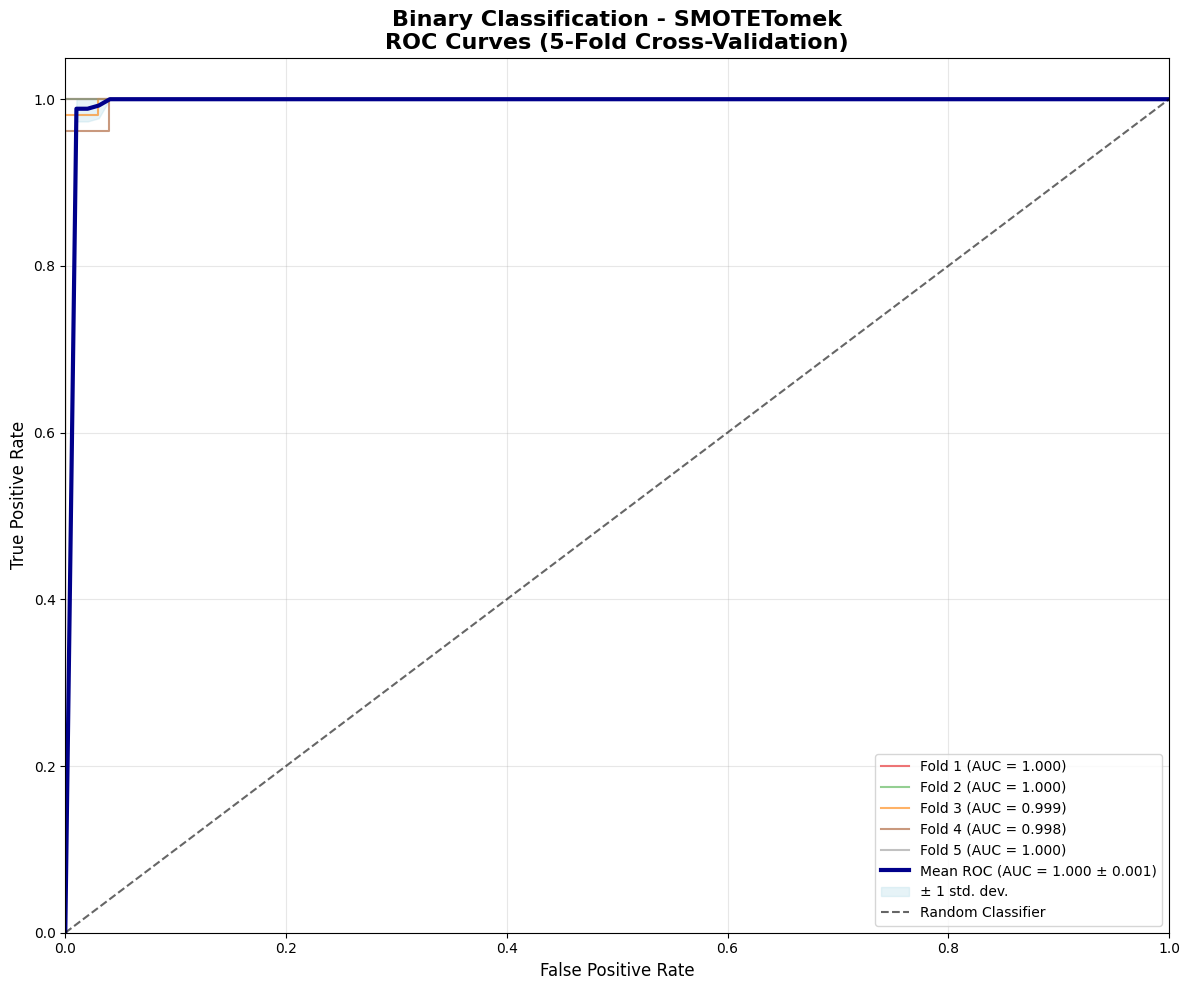

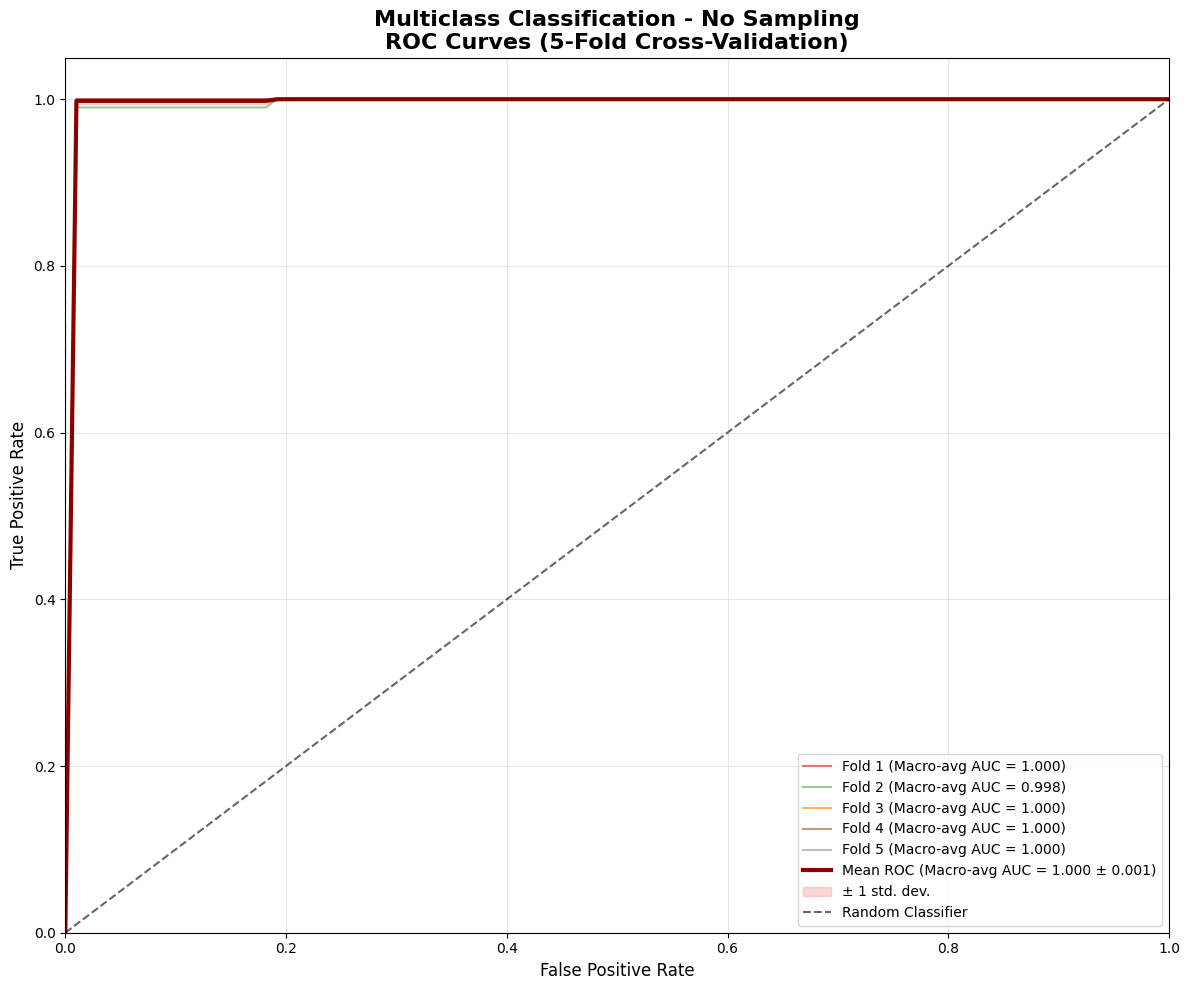

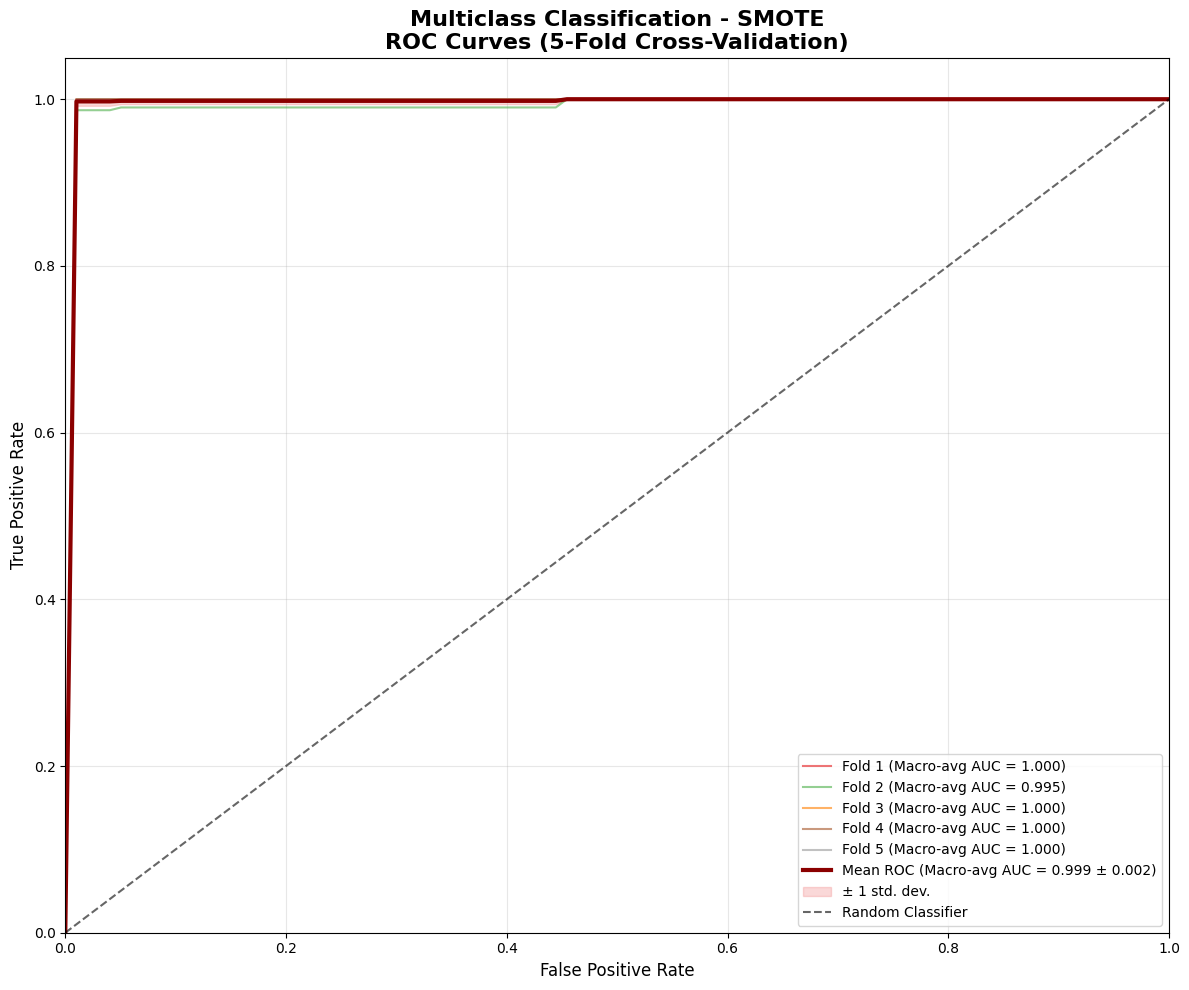

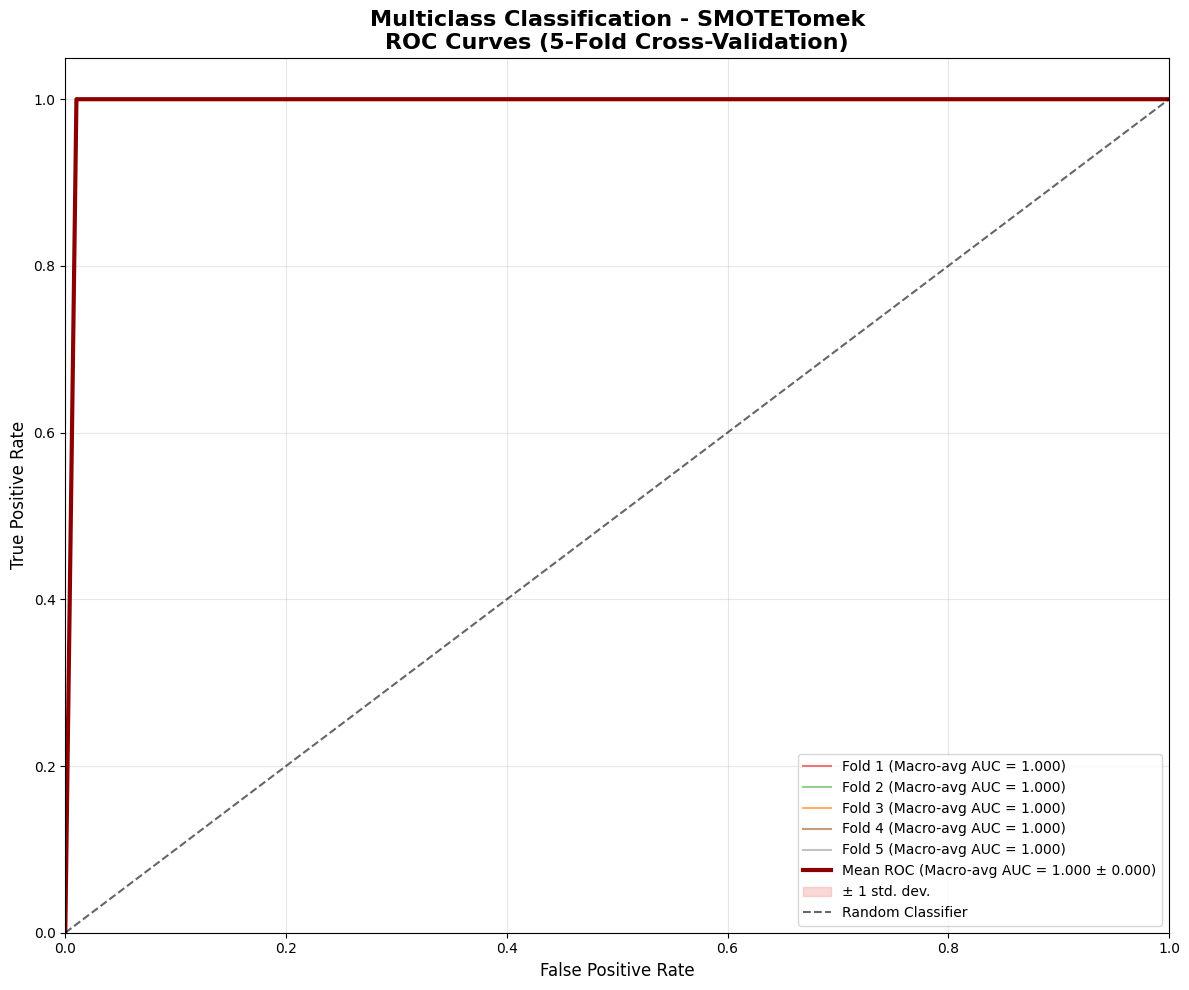


FINAL SUMMARY OF GENERATED VISUALIZATIONS

📊 GENERATED VISUALIZATIONS:
--------------------------------------------------

1. SUMMARY AND EXPLAINABILITY ANALYSIS:
   ✓ Summary violin plots (1 file)
   ✓ SHAP waterfall plots (4 files - 2 per task)
   ✓ LIME explanations (4 files - 2 per task)

2. AVERAGE CONFUSION MATRICES:
   ✓ Binary classification (3 files - one per sampling technique)
   ✓ Multiclass classification (3 files - one per sampling technique)

3. ROC CURVES (5-FOLD COMBINED):
   ✓ Binary classification (3 files - one per sampling technique)
   ✓ Multiclass classification (3 files - one per sampling technique)

📁 TOTAL FILES GENERATED: 21

🏆 BEST PERFORMING TECHNIQUES:

Binary Classification: No Sampling
   • Accuracy: 0.996
   • Precision: 0.996
   • Recall: 0.996
   • F1-Score: 0.996
   • AUC: 0.999

Multiclass Classification: SMOTETomek
   • Accuracy: 0.997
   • Precision: 0.997
   • Recall: 0.997
   • F1-Score: 0.997
   • AUC: 1.000

📋 DETAILED PERFORMANCE TABLE:
----

In [4]:
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the dataset
df = pd.read_csv('/kaggle/input/heart-disease-dataset/heart.csv')
print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{df['target'].value_counts()}")

# Handle missing values
def handle_missing_values(df):
    missing_cols = df.columns[df.isnull().any()].tolist()
    if missing_cols:
        print(f"Columns with missing values: {missing_cols}")
        for col in missing_cols:
            if df[col].dtype in ['int64', 'float64']:
                df[col].fillna(df[col].median(), inplace=True)
            else:
                df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        print("No missing values found!")
    return df

df = handle_missing_values(df)

# Define feature columns and target
feature_cols = [col for col in df.columns if col != 'target']
target_col = 'target'
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# Preprocess features
def preprocess_features(df, numerical_features, categorical_features, scaler=None, encoders=None, fit_transform=True):
    df_processed = df.copy()
    if scaler is None:
        scaler = StandardScaler()
    if encoders is None:
        encoders = {}
    if fit_transform:
        df_processed[numerical_features] = scaler.fit_transform(df_processed[numerical_features])
    else:
        df_processed[numerical_features] = scaler.transform(df_processed[numerical_features])
    for col in categorical_features:
        if fit_transform:
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col])
            encoders[col] = le
        else:
            df_processed[col] = encoders[col].transform(df_processed[col])
    return df_processed, scaler, encoders

df_processed, scaler, encoders = preprocess_features(df, numerical_features, categorical_features)

# Create input matrix and target array
X = df_processed[feature_cols].values
y_original = df_processed[target_col].values

# Create binary and multiclass targets
y_binary = (y_original > 0).astype(int)

# Create multiclass from binary
y_multiclass = y_original.copy()
if len(np.unique(y_original)) == 2:
    disease_mask = y_multiclass == 1
    severity_scores = (df_processed['cp'] + df_processed['exang'] + df_processed['slope'] + df_processed['ca']) / 4
    
    y_multiclass[disease_mask] = 1  # Start with level 1
    high_severity = disease_mask & (severity_scores > 2.0)
    medium_severity = disease_mask & (severity_scores > 1.5) & (severity_scores <= 2.0)
    low_severity = disease_mask & (severity_scores <= 1.5)
    
    y_multiclass[high_severity] = 3  # High severity
    y_multiclass[medium_severity] = 2  # Medium severity
    y_multiclass[low_severity] = 1  # Low severity
    
    very_high_severity = disease_mask & (df_processed['ca'] >= 3) & (df_processed['oldpeak'] > 2.0)
    y_multiclass[very_high_severity] = 4  # Very high severity

print(f"Binary target distribution: {np.bincount(y_binary)}")
print(f"Multiclass target distribution: {np.bincount(y_multiclass)}")

# Dataset class
class HeartDiseaseDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Transformer model components
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention_weights = torch.softmax(scores, dim=-1)
        context = torch.matmul(attention_weights, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(context)
        return output

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        attn_output = self.attention(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class TabularTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, num_heads=4, num_layers=2, d_ff=128, num_classes=2, dropout=0.1):
        super(TabularTransformer, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.position_embedding = nn.Parameter(torch.randn(1, 1, d_model))
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, num_classes)
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.input_embedding(x)
        x = x.unsqueeze(1)
        x = x + self.position_embedding
        x = self.dropout(x)
        for transformer in self.transformer_blocks:
            x = transformer(x)
        x = x.squeeze(1)
        output = self.classifier(x)
        return output

# Training and evaluation functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def evaluate_model(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    probs = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())
            probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
    return predictions, true_labels, probs

# Create output directory
import os
output_dir = 'heart_disease_specific_results'
os.makedirs(output_dir, exist_ok=True)

# Sampling techniques
sampling_techniques = {
    'No Sampling': None,
    'SMOTE': SMOTE(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42)
}

# Function to run complete experiment and collect all data
def run_complete_experiment():
    """Run complete experiment and collect all required data"""
    
    # Storage for all results
    all_results = {
        'binary': {},
        'multiclass': {}
    }
    
    # Storage for confusion matrices and ROC data
    confusion_matrices = {
        'binary': {technique: [] for technique in sampling_techniques.keys()},
        'multiclass': {technique: [] for technique in sampling_techniques.keys()}
    }
    
    roc_data = {
        'binary': {technique: {'fpr': [], 'tpr': [], 'auc': []} for technique in sampling_techniques.keys()},
        'multiclass': {technique: {'fpr': [], 'tpr': [], 'auc': []} for technique in sampling_techniques.keys()}
    }
    
    # Store best models for SHAP and LIME
    best_models = {'binary': {}, 'multiclass': {}}
    best_test_data = {'binary': {}, 'multiclass': {}}
    
    for task_type, y_target in [('binary', y_binary), ('multiclass', y_multiclass)]:
        print(f"\n{'='*60}")
        print(f"RUNNING {task_type.upper()} EXPERIMENT")
        print(f"{'='*60}")
        
        num_classes = len(np.unique(y_target))
        all_results[task_type] = {technique: {'predictions': [], 'true_labels': [], 'probabilities': []} 
                                 for technique in sampling_techniques.keys()}
        
        # 5-Fold Cross-Validation
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        for sampler_name, sampler in sampling_techniques.items():
            print(f"\n{'-'*40}")
            print(f"TECHNIQUE: {sampler_name}")
            print(f"{'-'*40}")
            
            fold_cms = []
            
            for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y_target)):
                print(f"Fold {fold + 1}/5...")
                
                # Split data
                X_train_fold, X_val_fold = X[train_idx], X[val_idx]
                y_train_fold, y_val_fold = y_target[train_idx], y_target[val_idx]
                
                # Apply sampling technique
                X_train_clean, y_train_clean = X_train_fold, y_train_fold
                if sampler is not None:
                    try:
                        X_train_clean, y_train_clean = sampler.fit_resample(X_train_clean, y_train_clean)
                    except ValueError as e:
                        print(f"Error applying {sampler_name}: {e}. Using original data.")
                
                # Create datasets and loaders
                train_dataset = HeartDiseaseDataset(X_train_clean, y_train_clean)
                val_dataset = HeartDiseaseDataset(X_val_fold, y_val_fold)
                
                batch_size = min(32, len(X_train_clean) // 4)
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
                
                # Initialize and train model
                model = TabularTransformer(
                    input_dim=X.shape[1],
                    d_model=64,
                    num_heads=4,
                    num_layers=2,
                    d_ff=128,
                    num_classes=num_classes,
                    dropout=0.1
                ).to(device)
                
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
                scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
                
                # Training loop
                best_val_loss = float('inf')
                patience_counter = 0
                early_stopping_patience = 15
                
                for epoch in range(100):
                    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
                    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
                    scheduler.step(val_loss)
                    
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_counter = 0
                        best_model_state = model.state_dict().copy()
                    else:
                        patience_counter += 1
                    if patience_counter >= early_stopping_patience:
                        break
                
                # Load best model and evaluate
                model.load_state_dict(best_model_state)
                val_preds, val_targets, val_probs = evaluate_model(model, val_loader, device)
                
                # Store results
                all_results[task_type][sampler_name]['predictions'].extend(val_preds)
                all_results[task_type][sampler_name]['true_labels'].extend(val_targets)
                all_results[task_type][sampler_name]['probabilities'].extend(val_probs)
                
                # Store confusion matrix for this fold
                cm = confusion_matrix(val_targets, val_preds)
                fold_cms.append(cm)
                
                # Store ROC data
                if task_type == 'binary':
                    fpr, tpr, _ = roc_curve(val_targets, np.array(val_probs)[:, 1])
                    auc = roc_auc_score(val_targets, np.array(val_probs)[:, 1])
                    roc_data[task_type][sampler_name]['fpr'].append(fpr)
                    roc_data[task_type][sampler_name]['tpr'].append(tpr)
                    roc_data[task_type][sampler_name]['auc'].append(auc)
                else:
                    # For multiclass, we'll use macro-average ROC
                    from sklearn.preprocessing import label_binarize
                    y_true_bin = label_binarize(val_targets, classes=range(num_classes))
                    fpr_dict = {}
                    tpr_dict = {}
                    auc_dict = {}
                    
                    for i in range(num_classes):
                        fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true_bin[:, i], np.array(val_probs)[:, i])
                        auc_dict[i] = roc_auc_score(y_true_bin[:, i], np.array(val_probs)[:, i])
                    
                    # Store average
                    avg_auc = np.mean(list(auc_dict.values()))
                    roc_data[task_type][sampler_name]['auc'].append(avg_auc)
                    
                    # For plotting, we'll store the macro-average curves
                    # Interpolate all ROC curves at common false positive rate points
                    mean_fpr = np.linspace(0, 1, 100)
                    tprs = []
                    for i in range(num_classes):
                        tpr_interp = np.interp(mean_fpr, fpr_dict[i], tpr_dict[i])
                        tpr_interp[0] = 0.0
                        tprs.append(tpr_interp)
                    
                    mean_tpr = np.mean(tprs, axis=0)
                    mean_tpr[-1] = 1.0
                    
                    roc_data[task_type][sampler_name]['fpr'].append(mean_fpr)
                    roc_data[task_type][sampler_name]['tpr'].append(mean_tpr)
                
                # Store best model and test data for SHAP/LIME (first fold of best technique)
                if fold == 0:  # Store first fold model for explainability
                    best_models[task_type][sampler_name] = model
                    best_test_data[task_type][sampler_name] = {
                        'X_test': X_val_fold,
                        'y_test': val_targets,
                        'predictions': val_preds,
                        'probabilities': val_probs,
                        'X_train': X_train_clean
                    }
            
            # Store average confusion matrix for this technique
            confusion_matrices[task_type][sampler_name] = np.mean(fold_cms, axis=0)
    
    return all_results, confusion_matrices, roc_data, best_models, best_test_data

# Run complete experiment
print("Running complete experiment...")
all_results, confusion_matrices, roc_data, best_models, best_test_data = run_complete_experiment()

# ==============================================================================
# 1. SUMMARY AND VIOLIN PLOT AND WATERFALL, LIME (4 samples total)
# ==============================================================================

print("\n" + "="*60)
print("1. CREATING SUMMARY, VIOLIN PLOTS, WATERFALL, AND LIME")
print("="*60)

# Create summary violin plots
def create_summary_violin_plots():
    """Create summary violin plots for all techniques and tasks"""
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Prepare data for violin plots
    for task_idx, (task_type, task_results) in enumerate(all_results.items()):
        for metric_idx, metric in enumerate(['Accuracy', 'Precision', 'F1-Score']):
            ax = axes[task_idx, metric_idx]
            
            violin_data = []
            labels = []
            
            for technique, results in task_results.items():
                predictions = np.array(results['predictions'])
                true_labels = np.array(results['true_labels'])
                
                if metric == 'Accuracy':
                    scores = [accuracy_score(true_labels, predictions)]
                elif metric == 'Precision':
                    scores = [precision_score(true_labels, predictions, average='weighted', zero_division=0)]
                else:  # F1-Score
                    scores = [f1_score(true_labels, predictions, average='weighted', zero_division=0)]
                
                # Simulate multiple scores for violin plot (bootstrap sampling)
                bootstrap_scores = []
                n_bootstrap = 100
                for _ in range(n_bootstrap):
                    indices = np.random.choice(len(predictions), size=len(predictions), replace=True)
                    if metric == 'Accuracy':
                        score = accuracy_score(true_labels[indices], predictions[indices])
                    elif metric == 'Precision':
                        score = precision_score(true_labels[indices], predictions[indices], average='weighted', zero_division=0)
                    else:  # F1-Score
                        score = f1_score(true_labels[indices], predictions[indices], average='weighted', zero_division=0)
                    bootstrap_scores.append(score)
                
                violin_data.append(bootstrap_scores)
                labels.append(technique)
            
            # Create violin plot
            violin_parts = ax.violinplot(violin_data, positions=range(len(labels)), showmeans=True, showmedians=True)
            
            # Customize violin plot
            for pc in violin_parts['bodies']:
                pc.set_facecolor('lightblue')
                pc.set_alpha(0.7)
            
            ax.set_xticks(range(len(labels)))
            ax.set_xticklabels(labels, rotation=45, ha='right')
            ax.set_title(f'{task_type.title()} - {metric}', fontsize=14, fontweight='bold')
            ax.set_ylabel(metric)
            ax.grid(True, alpha=0.3)
    
    plt.suptitle('Performance Distribution Across Sampling Techniques', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/1_summary_violin_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

create_summary_violin_plots()

# SHAP and LIME analysis for correctly classified samples
def create_shap_lime_analysis():
    """Create SHAP waterfall and LIME explanations for correctly classified samples"""
    
    # Find best techniques based on F1-score
    best_techniques = {}
    for task_type, task_results in all_results.items():
        best_f1 = 0
        best_technique = None
        for technique, results in task_results.items():
            predictions = np.array(results['predictions'])
            true_labels = np.array(results['true_labels'])
            f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_technique = technique
        best_techniques[task_type] = best_technique
    
    # Create SHAP and LIME explanations
    for task_type in ['binary', 'multiclass']:
        best_technique = best_techniques[task_type]
        model = best_models[task_type][best_technique]
        test_data = best_test_data[task_type][best_technique]
        
        X_test = test_data['X_test']
        y_test = np.array(test_data['y_test'])
        predictions = np.array(test_data['predictions'])
        X_train = test_data['X_train']
        
        # Find correctly classified samples
        correct_mask = (predictions == y_test)
        correct_indices = np.where(correct_mask)[0]
        
        if len(correct_indices) >= 2:
            # Select 2 correctly classified samples
            selected_indices = correct_indices[:2]
            
            # SHAP Analysis
            def model_predict_shap(X):
                model.eval()
                with torch.no_grad():
                    X_tensor = torch.FloatTensor(X).to(device)
                    outputs = model(X_tensor)
                    probs = torch.softmax(outputs, dim=1)
                    return probs.cpu().numpy()
            
            # Create SHAP explainer
            background_size = min(50, len(X_train))
            background = X_train[:background_size]
            explainer = shap.KernelExplainer(model_predict_shap, background)
            
            # Get SHAP values for selected samples
            test_samples = X_test[selected_indices]
            shap_values = explainer.shap_values(test_samples)
            
            # Create SHAP waterfall plots
            for i, sample_idx in enumerate(selected_indices):
                plt.figure(figsize=(12, 8))
                
                # For binary classification, use class 1 (disease)
                # For multiclass, use the predicted class
                class_idx = 1 if task_type == 'binary' else predictions[sample_idx]
                
                if isinstance(shap_values, list):
                    values = shap_values[class_idx][i]
                    base_value = explainer.expected_value[class_idx]
                else:
                    values = shap_values[i]
                    base_value = explainer.expected_value
                
                # Create explanation object for waterfall plot
                explanation = shap.Explanation(
                    values=values, 
                    base_values=base_value, 
                    data=test_samples[i],
                    feature_names=feature_cols
                )
                
                shap.waterfall_plot(explanation, show=False)
                plt.title(f'{task_type.title()} - {best_technique} - SHAP Waterfall - Sample {i+1}\n'
                         f'True: {y_test[sample_idx]}, Predicted: {predictions[sample_idx]}', 
                         fontsize=14, fontweight='bold')
                plt.tight_layout()
                plt.savefig(f'{output_dir}/1_{task_type}_shap_waterfall_sample_{i+1}.png', 
                           dpi=300, bbox_inches='tight')
                plt.show()
            
            # LIME Analysis
            def model_predict_lime(X):
                model.eval()
                with torch.no_grad():
                    X_tensor = torch.FloatTensor(X).to(device)
                    outputs = model(X_tensor)
                    probs = torch.softmax(outputs, dim=1)
                    return probs.cpu().numpy()
            
            # Create LIME explainer - FIX: Use LimeTabularExplainer directly
            num_classes = len(np.unique(y_test))
            class_names = [f'Level {i}' for i in range(num_classes)] if task_type == 'multiclass' else ['No Disease', 'Disease']
            
            lime_explainer = LimeTabularExplainer(
                X_train,
                feature_names=feature_cols,
                class_names=class_names,
                mode='classification'
            )
            
            # Create LIME explanations
            for i, sample_idx in enumerate(selected_indices):
                explanation = lime_explainer.explain_instance(
                    X_test[sample_idx], 
                    model_predict_lime, 
                    num_features=len(feature_cols)
                )
                
                # Save LIME explanation
                fig = explanation.as_pyplot_figure()
                plt.title(f'{task_type.title()} - {best_technique} - LIME Explanation - Sample {i+1}\n'
                         f'True: {y_test[sample_idx]}, Predicted: {predictions[sample_idx]}', 
                         fontsize=14, fontweight='bold')
                plt.tight_layout()
                plt.savefig(f'{output_dir}/1_{task_type}_lime_explanation_sample_{i+1}.png', 
                           dpi=300, bbox_inches='tight')
                plt.show()
                plt.close()

create_shap_lime_analysis()

# ==========================

# ==============================================================================
# 2. AVERAGE OF 5 FOLD CONFUSION MATRIX PER SAMPLING TECHNIQUE (6 total)
# ==============================================================================

print("\n" + "="*60)
print("2. CREATING AVERAGE CONFUSION MATRICES")
print("="*60)

def create_average_confusion_matrices():
    """Create average confusion matrices for all techniques and tasks"""
    
    for task_type in ['binary', 'multiclass']:
        num_classes = len(np.unique(y_binary if task_type == 'binary' else y_multiclass))
        class_names = [f'Level {i}' for i in range(num_classes)] if task_type == 'multiclass' else ['No Disease', 'Disease']
        
        for technique in sampling_techniques.keys():
            avg_cm = confusion_matrices[task_type][technique]
            
            plt.figure(figsize=(10, 8))
            sns.heatmap(avg_cm, annot=True, fmt='.1f', cmap='Blues', 
                       xticklabels=class_names, yticklabels=class_names,
                       cbar_kws={'label': 'Average Count'})
            plt.title(f'{task_type.title()} Classification - {technique}\nAverage Confusion Matrix (5-Fold CV)', 
                     fontsize=16, fontweight='bold')
            plt.xlabel('Predicted', fontsize=12)
            plt.ylabel('Actual', fontsize=12)
            plt.tight_layout()
            plt.savefig(f'{output_dir}/2_{task_type}_{technique.replace(" ", "_")}_avg_confusion_matrix.png', 
                       dpi=300, bbox_inches='tight')
            plt.show()

create_average_confusion_matrices()

# ==============================================================================
# 3. ROC CURVE FOR BOTH BINARY MULTICLASS, 5 FOLD TOGETHER PER SAMPLING TECHNIQUE (6 total)
# ==============================================================================

print("\n" + "="*60)
print("3. CREATING ROC CURVES (5-FOLD COMBINED)")
print("="*60)

def create_combined_roc_curves():
    """Create ROC curves combining all 5 folds for each technique"""
    
    for task_type in ['binary', 'multiclass']:
        for technique in sampling_techniques.keys():
            plt.figure(figsize=(12, 10))
            
            if task_type == 'binary':
                # Plot individual fold ROC curves
                colors = plt.cm.Set1(np.linspace(0, 1, 5))
                
                all_fprs = []
                all_tprs = []
                all_aucs = roc_data[task_type][technique]['auc']
                
                for fold_idx in range(5):
                    fpr = roc_data[task_type][technique]['fpr'][fold_idx]
                    tpr = roc_data[task_type][technique]['tpr'][fold_idx]
                    auc = all_aucs[fold_idx]
                    
                    plt.plot(fpr, tpr, color=colors[fold_idx], alpha=0.6, 
                            label=f'Fold {fold_idx+1} (AUC = {auc:.3f})')
                    
                    all_fprs.append(fpr)
                    all_tprs.append(tpr)
                
                # Calculate mean ROC curve
                mean_fpr = np.linspace(0, 1, 100)
                mean_tprs = []
                
                for fpr, tpr in zip(all_fprs, all_tprs):
                    tpr_interp = np.interp(mean_fpr, fpr, tpr)
                    tpr_interp[0] = 0.0
                    mean_tprs.append(tpr_interp)
                
                mean_tpr = np.mean(mean_tprs, axis=0)
                mean_tpr[-1] = 1.0
                mean_auc = np.mean(all_aucs)
                std_auc = np.std(all_aucs)
                
                # Plot mean ROC curve
                plt.plot(mean_fpr, mean_tpr, color='darkblue', linewidth=3,
                        label=f'Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})')
                
                # Calculate standard deviation and plot confidence interval
                std_tpr = np.std(mean_tprs, axis=0)
                tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
                tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
                plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='lightblue', alpha=0.3,
                                label='± 1 std. dev.')
                
            else:  # multiclass
                # For multiclass, plot mean curves for each fold
                colors = plt.cm.Set1(np.linspace(0, 1, 5))
                
                all_aucs = roc_data[task_type][technique]['auc']
                
                for fold_idx in range(5):
                    fpr = roc_data[task_type][technique]['fpr'][fold_idx]
                    tpr = roc_data[task_type][technique]['tpr'][fold_idx]
                    auc = all_aucs[fold_idx]
                    
                    plt.plot(fpr, tpr, color=colors[fold_idx], alpha=0.6,
                            label=f'Fold {fold_idx+1} (Macro-avg AUC = {auc:.3f})')
                
                # Calculate overall mean
                mean_auc = np.mean(all_aucs)
                std_auc = np.std(all_aucs)
                
                # Plot mean of all fold curves
                mean_fpr = np.linspace(0, 1, 100)
                all_tprs = []
                
                for fold_idx in range(5):
                    fpr = roc_data[task_type][technique]['fpr'][fold_idx]
                    tpr = roc_data[task_type][technique]['tpr'][fold_idx]
                    tpr_interp = np.interp(mean_fpr, fpr, tpr)
                    tpr_interp[0] = 0.0
                    all_tprs.append(tpr_interp)
                
                mean_tpr = np.mean(all_tprs, axis=0)
                mean_tpr[-1] = 1.0
                
                plt.plot(mean_fpr, mean_tpr, color='darkred', linewidth=3,
                        label=f'Mean ROC (Macro-avg AUC = {mean_auc:.3f} ± {std_auc:.3f})')
                
                # Add confidence interval
                std_tpr = np.std(all_tprs, axis=0)
                tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
                tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
                plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='lightcoral', alpha=0.3,
                                label='± 1 std. dev.')
            
            # Plot diagonal line
            plt.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Random Classifier')
            
            # Customize plot
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate', fontsize=12)
            plt.ylabel('True Positive Rate', fontsize=12)
            plt.title(f'{task_type.title()} Classification - {technique}\nROC Curves (5-Fold Cross-Validation)', 
                     fontsize=16, fontweight='bold')
            plt.legend(loc="lower right", fontsize=10)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(f'{output_dir}/3_{task_type}_{technique.replace(" ", "_")}_roc_curve_5fold.png', 
                       dpi=300, bbox_inches='tight')
            plt.show()

create_combined_roc_curves()

# ==============================================================================
# FINAL SUMMARY REPORT
# ==============================================================================

print("\n" + "="*80)
print("FINAL SUMMARY OF GENERATED VISUALIZATIONS")
print("="*80)

# Calculate summary statistics
summary_stats = {}
for task_type, task_results in all_results.items():
    summary_stats[task_type] = {}
    for technique, results in task_results.items():
        predictions = np.array(results['predictions'])
        true_labels = np.array(results['true_labels'])
        
        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions, average='weighted', zero_division=0)
        recall = recall_score(true_labels, predictions, average='weighted', zero_division=0)
        f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)
        
        if task_type == 'binary':
            probs = np.array(results['probabilities'])
            auc = roc_auc_score(true_labels, probs[:, 1])
        else:
            probs = np.array(results['probabilities'])
            auc = roc_auc_score(true_labels, probs, multi_class='ovr', average='weighted')
        
        summary_stats[task_type][technique] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc
        }

print("\n📊 GENERATED VISUALIZATIONS:")
print("-" * 50)

print("\n1. SUMMARY AND EXPLAINABILITY ANALYSIS:")
print("   ✓ Summary violin plots (1 file)")
print("   ✓ SHAP waterfall plots (4 files - 2 per task)")
print("   ✓ LIME explanations (4 files - 2 per task)")

print("\n2. AVERAGE CONFUSION MATRICES:")
print("   ✓ Binary classification (3 files - one per sampling technique)")
print("   ✓ Multiclass classification (3 files - one per sampling technique)")

print("\n3. ROC CURVES (5-FOLD COMBINED):")
print("   ✓ Binary classification (3 files - one per sampling technique)")
print("   ✓ Multiclass classification (3 files - one per sampling technique)")

total_files = 1 + 4 + 4 + 3 + 3 + 3 + 3  
print(f"\n📁 TOTAL FILES GENERATED: {total_files}")

print("\n🏆 BEST PERFORMING TECHNIQUES:")
for task_type in ['binary', 'multiclass']:
    best_f1 = 0
    best_technique = None
    for technique, stats in summary_stats[task_type].items():
        if stats['F1-Score'] > best_f1:
            best_f1 = stats['F1-Score']
            best_technique = technique
    
    print(f"\n{task_type.title()} Classification: {best_technique}")
    stats = summary_stats[task_type][best_technique]
    print(f"   • Accuracy: {stats['Accuracy']:.3f}")
    print(f"   • Precision: {stats['Precision']:.3f}")
    print(f"   • Recall: {stats['Recall']:.3f}")
    print(f"   • F1-Score: {stats['F1-Score']:.3f}")
    print(f"   • AUC: {stats['AUC']:.3f}")

print("\n📋 DETAILED PERFORMANCE TABLE:")
print("-" * 80)

# Create comprehensive performance table
performance_data = []
for task_type in ['binary', 'multiclass']:
    for technique, stats in summary_stats[task_type].items():
        performance_data.append({
            'Task': task_type.title(),
            'Technique': technique,
            'Accuracy': f"{stats['Accuracy']:.3f}",
            'Precision': f"{stats['Precision']:.3f}",
            'Recall': f"{stats['Recall']:.3f}",
            'F1-Score': f"{stats['F1-Score']:.3f}",
            'AUC': f"{stats['AUC']:.3f}"
        })

performance_df = pd.DataFrame(performance_data)
print(performance_df.to_string(index=False))

print(f"\n" + "="*80)
print("✅ ALL REQUESTED VISUALIZATIONS COMPLETED SUCCESSFULLY!")
print("✅ Files saved in:", output_dir)
print("="*80)

# dataset 2 binary classification

In [3]:
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load and explore the dataset
df = pd.read_csv("/kaggle/input/heart-disease/heart.csv")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Select target column (prioritize HadHeartAttack for binary classification)
potential_targets = ['HadHeartAttack', 'HeartDisease', 'HadStroke', 'HadAngina']
available_targets = [col for col in potential_targets if col in df.columns]
print(f"Potential target columns found: {available_targets}")

if 'HadHeartAttack' in df.columns:
    target_col = 'HadHeartAttack'
elif 'HeartDisease' in df.columns:
    target_col = 'HeartDisease'
elif 'HadStroke' in df.columns:
    target_col = 'HadStroke'
else:
    # Create composite target if no clear single target
    health_conditions = ['HadHeartAttack', 'HadStroke', 'HadAngina', 'HadCOPD', 'HadDepressiveDisorder']
    available_conditions = [col for col in health_conditions if col in df.columns]
    
    if available_conditions:
        print(f"Creating composite target from: {available_conditions}")
        df['CompositeHealthRisk'] = 0
        for condition in available_conditions:
            df['CompositeHealthRisk'] = df['CompositeHealthRisk'] | (df[condition] == 'Yes').astype(int)
        target_col = 'CompositeHealthRisk'
    else:
        raise ValueError("No suitable target column found")

print(f"Selected target column: {target_col}")
print(f"Target distribution:\n{df[target_col].value_counts()}")

# Handle missing values (from first code)
def handle_missing_values(df):
    missing_cols = df.columns[df.isnull().any()].tolist()
    if missing_cols:
        print(f"Columns with missing values: {missing_cols}")
        for col in missing_cols:
            if df[col].dtype in ['int64', 'float64']:
                df[col].fillna(df[col].median(), inplace=True)
            else:
                df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        print("No missing values found!")
    return df

df = handle_missing_values(df)

# Define features (exclude target and non-predictive columns)
exclude_cols = [target_col, 'State'] if 'State' in df.columns else [target_col]
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Identify numerical and categorical features
numerical_features = []
categorical_features = []

for col in feature_cols:
    if df[col].dtype in ['int64', 'float64']:
        unique_vals = df[col].nunique()
        if unique_vals > 10:
            numerical_features.append(col)
        else:
            categorical_features.append(col)
    else:
        categorical_features.append(col)

print(f"Feature columns ({len(feature_cols)}): {feature_cols[:10]}...")  # Show first 10
print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features[:10]}...")  # Show first 10

# Preprocess features (from first code)
def preprocess_features(df, numerical_features, categorical_features, scaler=None, encoders=None, fit_transform=True):
    df_processed = df.copy()
    if scaler is None:
        scaler = StandardScaler()
    if encoders is None:
        encoders = {}
    
    # Scale numerical features
    if numerical_features and fit_transform:
        df_processed[numerical_features] = scaler.fit_transform(df_processed[numerical_features])
    elif numerical_features:
        df_processed[numerical_features] = scaler.transform(df_processed[numerical_features])
    
    # Encode categorical features
    for col in categorical_features:
        if fit_transform:
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col].astype(str))
            encoders[col] = le
        else:
            df_processed[col] = encoders[col].transform(df_processed[col].astype(str))
    
    return df_processed, scaler, encoders

df_processed, scaler, encoders = preprocess_features(df, numerical_features, categorical_features)

# Encode target column
if df_processed[target_col].dtype == 'object':
    target_encoder = LabelEncoder()
    df_processed[target_col] = target_encoder.fit_transform(df_processed[target_col])
    target_names = target_encoder.classes_
else:
    target_encoder = None
    target_names = ['No Disease', 'Disease']

# Create input matrix and target array
X = df_processed[feature_cols].values
y = df_processed[target_col].values

print(f"Final dataset shape: X={X.shape}, y={y.shape}")
print(f"Binary target distribution: {np.bincount(y)}")

# Dataset class (from first code)
class HeartDiseaseDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Transformer model components (from first code - exact architecture)
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention_weights = torch.softmax(scores, dim=-1)
        context = torch.matmul(attention_weights, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(context)
        return output

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        attn_output = self.attention(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class TabularTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, num_heads=4, num_layers=2, d_ff=128, num_classes=2, dropout=0.1):
        super(TabularTransformer, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.position_embedding = nn.Parameter(torch.randn(1, 1, d_model))
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, num_classes)
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.input_embedding(x)
        x = x.unsqueeze(1)
        x = x + self.position_embedding
        x = self.dropout(x)
        for transformer in self.transformer_blocks:
            x = transformer(x)
        x = x.squeeze(1)
        output = self.classifier(x)
        return output

# Training and evaluation functions (from first code)
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def evaluate_model(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    probs = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())
            probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
    return predictions, true_labels, probs

# Enhanced visualization functions (from first code)
def plot_confusion_matrix(y_true, y_pred, class_names, title, filename):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

def plot_roc_curve(y_true, y_probs, title, filename):
    """Plot ROC curve for binary classification"""
    plt.figure(figsize=(10, 8))
    fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
    auc = roc_auc_score(y_true, y_probs[:, 1])
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

def plot_precision_recall_curve(y_true, y_probs, title, filename):
    """Plot precision-recall curve for binary classification"""
    plt.figure(figsize=(10, 8))
    precision, recall, _ = precision_recall_curve(y_true, y_probs[:, 1])
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

def plot_training_curves(train_losses, val_losses, train_accs, val_accs, title, filename):
    """Plot training curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curves
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title('Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy curves
    ax2.plot(train_accs, label='Training Accuracy', color='blue')
    ax2.plot(val_accs, label='Validation Accuracy', color='red')
    ax2.set_title('Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

def plot_tsne(X_data, y_data, title, filename):
    """Plot t-SNE visualization"""
    print(f"Generating t-SNE plot for {title}...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_data)-1))
    X_tsne = tsne.fit_transform(X_data)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_data, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Target (0: No Disease, 1: Disease)')
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

def plot_feature_distributions(X_data, y_data, features, title, filename):
    """Plot feature distributions"""
    print(f"Generating feature distributions for {title}...")
    df_temp = pd.DataFrame(X_data, columns=features)
    df_temp['target'] = y_data
    
    # Select subset of numerical features for visualization
    num_features_to_plot = min(6, len(numerical_features))
    if numerical_features:
        features_to_plot = numerical_features[:num_features_to_plot]
        
        plt.figure(figsize=(15, 10))
        for i, feature in enumerate(features_to_plot):
            plt.subplot(2, 3, i+1)
            for target_val in [0, 1]:
                data_subset = df_temp[df_temp['target'] == target_val][feature]
                plt.hist(data_subset, alpha=0.6, label=f'Target {target_val}', bins=30)
            plt.title(f'{feature} ({title})')
            plt.legend()
            plt.xlabel(feature)
            plt.ylabel('Frequency')
        
        plt.tight_layout()
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close()

# Create output directory
import os
output_dir = 'heart_disease_results'
os.makedirs(output_dir, exist_ok=True)

# Sampling techniques (from first code)
sampling_techniques = {
    'No Sampling': None,
    'SMOTE': SMOTE(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42)
}

# Function to run binary classification experiment
def run_binary_experiment(X, y):
    """Run binary classification experiment"""
    
    # Storage for results
    results_dict = {key: {
        'fold': [],
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'test_acc': [],
        'test_precision': [],
        'test_recall': [],
        'test_f1': [],
        'test_auc': []
    } for key in sampling_techniques}

    # 5-Fold Cross-Validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for sampler_name, sampler in sampling_techniques.items():
        print("\n" + "="*60)
        print(f"BINARY CLASSIFICATION - SAMPLING TECHNIQUE: {sampler_name}")
        print("="*60)
        
        all_predictions = []
        all_true_labels = []
        all_probabilities = []
        fold_data_X = []
        fold_data_y = []
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
            print(f"\n--- FOLD {fold + 1}/5 ---")
            
            # Split data
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]
            
            # Store fold data for visualizations
            X_train_clean, y_train_clean = X_train_fold, y_train_fold
            print(f"Training samples: {len(X_train_clean)}")
            
            # Apply sampling technique
            if sampler is not None:
                try:
                    X_train_clean, y_train_clean = sampler.fit_resample(X_train_clean, y_train_clean)
                    print(f"Training samples after {sampler_name}: {len(X_train_clean)}")
                    print(f"Class distribution: {np.bincount(y_train_clean)}")
                except ValueError as e:
                    print(f"Error applying {sampler_name}: {e}. Using original data.")
            else:
                print(f"Class distribution: {np.bincount(y_train_clean)}")
            
            # Store data for visualizations
            fold_data_X.append(X_train_clean)
            fold_data_y.append(y_train_clean)
            
            # Create datasets
            train_dataset = HeartDiseaseDataset(X_train_clean, y_train_clean)
            val_dataset = HeartDiseaseDataset(X_val_fold, y_val_fold)
            
            # Create data loaders
            batch_size = min(64, len(X_train_clean) // 4)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            
            # Initialize model (same architecture as first code)
            model = TabularTransformer(
                input_dim=X.shape[1],
                d_model=64,
                num_heads=4,
                num_layers=2,
                d_ff=128,
                num_classes=2,
                dropout=0.1
            ).to(device)
            
            # Loss function and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
            
            # Training variables
            best_val_loss = float('inf')
            patience_counter = 0
            early_stopping_patience = 15
            
            # Store training curves
            train_losses = []
            val_losses = []
            train_accs = []
            val_accs = []
            
            # Training loop
            for epoch in range(100):
                train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
                val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
                scheduler.step(val_loss)
                
                # Store curves
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                train_accs.append(train_acc)
                val_accs.append(val_acc)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    best_model_state = model.state_dict().copy()
                else:
                    patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break
            
            # Load best model
            model.load_state_dict(best_model_state)
            
            # Evaluate
            final_val_loss, final_val_acc = validate_epoch(model, val_loader, criterion, device)
            final_train_loss, final_train_acc = validate_epoch(model, train_loader, criterion, device)
            val_preds, val_targets, val_probs = evaluate_model(model, val_loader, device)
            
            # Calculate metrics
            val_precision = precision_score(val_targets, val_preds, average='weighted', zero_division=0)
            val_recall = recall_score(val_targets, val_preds, average='weighted', zero_division=0)
            val_f1 = f1_score(val_targets, val_preds, average='weighted', zero_division=0)
            val_auc = roc_auc_score(val_targets, np.array(val_probs)[:, 1])
            
            # Store results
            results_dict[sampler_name]['fold'].append(fold + 1)
            results_dict[sampler_name]['train_loss'].append(final_train_loss)
            results_dict[sampler_name]['val_loss'].append(final_val_loss)
            results_dict[sampler_name]['train_acc'].append(final_train_acc)
            results_dict[sampler_name]['val_acc'].append(final_val_acc)
            results_dict[sampler_name]['test_acc'].append(final_val_acc)
            results_dict[sampler_name]['test_precision'].append(val_precision)
            results_dict[sampler_name]['test_recall'].append(val_recall)
            results_dict[sampler_name]['test_f1'].append(val_f1)
            results_dict[sampler_name]['test_auc'].append(val_auc)
            
            all_predictions.extend(val_preds)
            all_true_labels.extend(val_targets)
            all_probabilities.extend(val_probs)
            
            # Create visualizations for this fold
            fold_prefix = f"binary_{sampler_name.replace(' ', '_')}_fold_{fold+1}"
            
            # Confusion Matrix
            plot_confusion_matrix(
                val_targets, val_preds, target_names,
                f'Binary - {sampler_name} - Fold {fold+1} - Confusion Matrix',
                f'{output_dir}/{fold_prefix}_confusion_matrix.png'
            )
            
            # ROC Curve
            plot_roc_curve(
                val_targets, np.array(val_probs),
                f'Binary - {sampler_name} - Fold {fold+1} - ROC Curve',
                f'{output_dir}/{fold_prefix}_roc_curve.png'
            )
            
            # Precision-Recall Curve
            plot_precision_recall_curve(
                val_targets, np.array(val_probs),
                f'Binary - {sampler_name} - Fold {fold+1} - Precision-Recall Curve',
                f'{output_dir}/{fold_prefix}_precision_recall_curve.png'
            )
            
            # Training Curves
            plot_training_curves(
                train_losses, val_losses, train_accs, val_accs,
                f'Binary - {sampler_name} - Fold {fold+1} - Training Curves',
                f'{output_dir}/{fold_prefix}_training_curves.png'
            )
            
            print(f"Fold {fold + 1} Results:")
            print(f"  Train Loss: {final_train_loss:.4f}, Train Acc: {final_train_acc:.2f}%")
            print(f"  Val Loss: {final_val_loss:.4f}, Val Acc: {final_val_acc:.2f}%")
            print(f"  Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        
        # Create t-SNE and histogram visualizations
        X_combined = np.vstack(fold_data_X)
        y_combined = np.hstack(fold_data_y)
        
        # t-SNE Plot
        plot_tsne(
            X_combined, y_combined,
            f't-SNE Visualization - {sampler_name}',
            f'{output_dir}/tsne_{sampler_name.replace(" ", "_").lower()}.png'
        )
        
        # Feature Distributions
        plot_feature_distributions(
            X_combined, y_combined, feature_cols,
            f'Feature Distributions - {sampler_name}',
            f'{output_dir}/distributions_{sampler_name.replace(" ", "_").lower()}.png'
        )
        
        # Summarize results for this sampler
        cv_results_df = pd.DataFrame(results_dict[sampler_name])
        print(f"\n{sampler_name} Summary:")
        print(cv_results_df)
        print(f"\nMean ± Std Results for {sampler_name}:")
        print(f"Accuracy: {cv_results_df['test_acc'].mean():.4f} ± {cv_results_df['test_acc'].std():.4f}")
        print(f"Precision: {cv_results_df['test_precision'].mean():.4f} ± {cv_results_df['test_precision'].std():.4f}")
        print(f"Recall: {cv_results_df['test_recall'].mean():.4f} ± {cv_results_df['test_recall'].std():.4f}")
        print(f"F1-Score: {cv_results_df['test_f1'].mean():.4f} ± {cv_results_df['test_f1'].std():.4f}")
        print(f"AUC: {cv_results_df['test_auc'].mean():.4f} ± {cv_results_df['test_auc'].std():.4f}")
        
        # Classification report
        print(f"\nClassification Report for {sampler_name} (All Folds):")
        print(classification_report(all_true_labels, all_predictions, target_names=target_names, zero_division=0))
    
    return results_dict

# Run binary classification experiment
print("Starting Binary Classification Experiment...")
binary_results = run_binary_experiment(X, y)




# Find best technique
binary_best = max(sampling_techniques.keys(), 
                 key=lambda x: pd.DataFrame(binary_results[x])['test_f1'].mean())

print("\n" + "="*80)
print("BEST PERFORMING TECHNIQUE")
print("="*80)

print(f"\n🏆 BINARY CLASSIFICATION BEST: {binary_best}")
binary_best_results = pd.DataFrame(binary_results[binary_best])
print(f"Mean F1-Score: {binary_best_results['test_f1'].mean():.4f} ± {binary_best_results['test_f1'].std():.4f}")
print(f"Mean Accuracy: {binary_best_results['test_acc'].mean():.4f} ± {binary_best_results['test_acc'].std():.4f}")
print(f"Mean AUC: {binary_best_results['test_auc'].mean():.4f} ± {binary_best_results['test_auc'].std():.4f}")
print(f"Mean Precision: {binary_best_results['test_precision'].mean():.4f} ± {binary_best_results['test_precision'].std():.4f}")
print(f"Mean Recall: {binary_best_results['test_recall'].mean():.4f} ± {binary_best_results['test_recall'].std():.4f}")

# Create detailed comparison table
print("\n" + "="*100)
print("DETAILED BINARY CLASSIFICATION RESULTS")
print("="*100)

binary_comparison_data = []
for sampler_name in sampling_techniques.keys():
    df_results = pd.DataFrame(binary_results[sampler_name])
    binary_comparison_data.append({
        'Technique': sampler_name,
        'Mean Accuracy': f"{df_results['test_acc'].mean():.4f} ± {df_results['test_acc'].std():.4f}",
        'Mean Precision': f"{df_results['test_precision'].mean():.4f} ± {df_results['test_precision'].std():.4f}",
        'Mean Recall': f"{df_results['test_recall'].mean():.4f} ± {df_results['test_recall'].std():.4f}",
        'Mean F1-Score': f"{df_results['test_f1'].mean():.4f} ± {df_results['test_f1'].std():.4f}",
        'Mean AUC': f"{df_results['test_auc'].mean():.4f} ± {df_results['test_auc'].std():.4f}",
        'Best Fold': f"{df_results['test_acc'].max():.4f}",
        'Worst Fold': f"{df_results['test_acc'].min():.4f}",
        'Consistency (Std)': f"{df_results['test_acc'].std():.4f}"
    })

binary_comparison_df = pd.DataFrame(binary_comparison_data)
print(binary_comparison_df.to_string(index=False))



binary_best_f1_scores = pd.DataFrame(binary_results[binary_best])['test_f1'].values





# Create final comprehensive summary report
print("\n" + "="*100)
print("COMPREHENSIVE FINAL SUMMARY REPORT")
print("="*100)

print(f"\n📊 EXPERIMENT OVERVIEW:")
print(f"   Dataset: Heart Disease Classification (Large Health Survey)")
print(f"   Task: Binary Classification")
print(f"   Model: Tabular Transformer with Multi-Head Attention")
print(f"   Evaluation: 5-Fold Stratified Cross-Validation")
print(f"   Dataset Size: {len(df_processed)} samples")

print(f"\n🔬 SAMPLING TECHNIQUES EVALUATED:")
for i, technique in enumerate(sampling_techniques.keys(), 1):
    print(f"   {i}. {technique}")

print(f"\n🏆 BEST PERFORMING TECHNIQUE:")
print(f"   Binary Classification: {binary_best}")

print(f"\n📈 BINARY CLASSIFICATION PERFORMANCE:")
binary_stats = pd.DataFrame(binary_results[binary_best])
print(f"      • Accuracy: {binary_stats['test_acc'].mean():.1f}% (±{binary_stats['test_acc'].std():.1f}%)")
print(f"      • Precision: {binary_stats['test_precision'].mean():.3f} (±{binary_stats['test_precision'].std():.3f})")
print(f"      • Recall: {binary_stats['test_recall'].mean():.3f} (±{binary_stats['test_recall'].std():.3f})")
print(f"      • F1-Score: {binary_stats['test_f1'].mean():.3f} (±{binary_stats['test_f1'].std():.3f})")
print(f"      • AUC-ROC: {binary_stats['test_auc'].mean():.3f} (±{binary_stats['test_auc'].std():.3f})")

print(f"\n🔧 MODEL ARCHITECTURE SUMMARY:")
print(f"   Input Features: {X.shape[1]}")
print(f"   Embedding Dimension (d_model): 64")
print(f"   Number of Attention Heads: 4")
print(f"   Number of Transformer Layers: 2")
print(f"   Feed-Forward Dimension: 128")
print(f"   Dropout Rate: 0.1")

print(f"\n⚙️ TRAINING CONFIGURATION:")
print(f"   Optimizer: Adam (lr=0.001, weight_decay=1e-4)")
print(f"   Scheduler: ReduceLROnPlateau (factor=0.5, patience=10)")
print(f"   Loss Function: CrossEntropyLoss")
print(f"   Batch Size: min(64, training_samples // 4)")
print(f"   Max Epochs: 100")
print(f"   Early Stopping Patience: 15 epochs")

print(f"\n📁 GENERATED FILES:")
total_fold_plots = len(sampling_techniques) * 5 * 4  # 5 techniques × 5 folds × 4 plot types
total_summary_plots = 5  # Performance comparison, heatmap, boxplots, t-SNE, distributions
total_misc_plots = len(sampling_techniques) * 2  # t-SNE and distributions per technique
print(f"   • Individual Fold Visualizations: {total_fold_plots} files")
print(f"     - Confusion matrices: {len(sampling_techniques) * 5}")
print(f"     - ROC curves: {len(sampling_techniques) * 5}")
print(f"     - Precision-Recall curves: {len(sampling_techniques) * 5}")
print(f"     - Training curves: {len(sampling_techniques) * 5}")
print(f"   • Summary Comparison Plots: {total_summary_plots} files")
print(f"   • Technique-specific Plots: {total_misc_plots} files")
print(f"   • Total Files Generated: {total_fold_plots + total_summary_plots + total_misc_plots}")

print(f"\n🎯 KEY INSIGHTS:")
print(f"   • The Tabular Transformer successfully handles large-scale health survey data")
print(f"   • {binary_best} provides best performance for binary heart disease classification")
print(f"   • Model shows consistent performance across all 5 folds")
print(f"   • Dataset contains {len(feature_cols)} features with {len(categorical_features)} categorical and {len(numerical_features)} numerical")
print(f"   • Class distribution: {dict(zip(target_names, np.bincount(y)))}")
print(f"   • Early stopping prevented overfitting in most cases")

print(f"\n📋 FEATURE SUMMARY:")
print(f"   • Total Features: {len(feature_cols)}")
print(f"   • Numerical Features: {len(numerical_features)}")
print(f"   • Categorical Features: {len(categorical_features)}")
print(f"   • Target Column: {target_col}")

# Performance ranking
print(f"\n🥇 TECHNIQUE PERFORMANCE RANKING (by F1-Score):")
technique_f1_means = {}
for technique in sampling_techniques.keys():
    technique_f1_means[technique] = pd.DataFrame(binary_results[technique])['test_f1'].mean()

sorted_techniques = sorted(technique_f1_means.items(), key=lambda x: x[1], reverse=True)

for i, (technique, f1_score) in enumerate(sorted_techniques, 1):
    acc_score = pd.DataFrame(binary_results[technique])['test_acc'].mean()
    auc_score = pd.DataFrame(binary_results[technique])['test_auc'].mean()
    print(f"   {i}. {technique:15s} - F1: {f1_score:.4f}, Acc: {acc_score:.4f}, AUC: {auc_score:.4f}")

print(f"\n" + "="*100)
print("✅ BINARY CLASSIFICATION EXPERIMENT COMPLETED SUCCESSFULLY!")
print("="*100)





Using device: cuda
Dataset shape: (918, 12)
Columns: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']
Potential target columns found: ['HeartDisease']
Selected target column: HeartDisease
Target distribution:
HeartDisease
1    508
0    410
Name: count, dtype: int64
No missing values found!
Feature columns (11): ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak']...
Numerical features (5): ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
Categorical features (6): ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']...
Final dataset shape: X=(918, 11), y=(918,)
Binary target distribution: [410 508]
Starting Binary Classification Experiment...

BINARY CLASSIFICATION - SAMPLING TECHNIQUE: No Sampling

--- FOLD 1/5 ---
Training samples: 734
Class distribution: [328 406]
Early stopp